# **Assignment 2: Stance Detection in Tweets using Deep Learning on SemEval 2 task 6 data.**

# Setting notebook and related packages and methods.





First we mount the google drive so that we can access the data files from the system

In [72]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [73]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)


In [74]:
! pip install -U spacy-Lookups-data

Requirement already up-to-date: spacy-Lookups-data in /usr/local/lib/python3.6/dist-packages (0.3.2)


In [75]:
!python -m spacy download en_core_web_sm 

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [76]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [77]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


The next step is to do some preliminary steps like importing related packages and setting up tensorboard and plotter function .

In [265]:
# Importing Related Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
import string

import re
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS


import pathlib
import shutil
import tempfile
from  IPython import display


result_df = pd.DataFrame(columns = ['model', 'F1_score'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Loading Tensorboard
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

In [80]:
# Plotter Function to plot performance of models

from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# Reading data and exploring related features


We use simple read_csv function to read the training as well as test data into dataframes.
We can see from the below output that, train data has 2914 values of 5 different features while test data has 1956 values of 5 features.

In [81]:
# Reading Training and Test datasets
train_data = "/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/StanceDataset/train.csv"
test_data = "/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/StanceDataset/test.csv"
#train_data = "/content/drive/My Drive/Colab Notebooks/TweetsDataset/train.csv"
#test_data = "/content/drive/My Drive/Colab Notebooks/TweetsDataset/test.csv"

traindata = pd.read_csv(train_data, engine='python')
testdata = pd.read_csv(test_data, engine='python')
print(traindata.shape)
print(testdata.shape)

(2914, 5)
(1956, 5)


The features of the dataset are : Tweet, Target, Stance, Opinion_towards and Sentiment. Out of which our main aim is to predict the Stance of a tweet if Tweet and Target is provided. So for our experiment, we dont need fetures like Opinion_towards and Sentiment.

In [82]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            2914 non-null   object
 1   Target           2914 non-null   object
 2   Stance           2914 non-null   object
 3   Opinion Towards  2914 non-null   object
 4   Sentiment        2914 non-null   object
dtypes: object(5)
memory usage: 114.0+ KB


In [83]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            1956 non-null   object
 1   Target           1956 non-null   object
 2   Stance           1956 non-null   object
 3   Opinion Towards  1956 non-null   object
 4   Sentiment        1956 non-null   object
dtypes: object(5)
memory usage: 76.5+ KB


We can see from the below code output that, traindata consists of tweets related to 5 different Target values namely,

1.   Hillary Clinton
2.   Feminist Movement
3.   Legalization of abortion
4.   Atheism
5.   Climate Change is a Real Concern

And the tweets are classified into 3 Stance values namely,

1.   tweets that FAVOR the target value
2.   Tweets which are AGAINST the target value
3.   Tweets which are neither in FAVOR nor AGAINST (i.e. NONE)

We can see the number tweets for each target value as well as number of tweets of eah Stance values described below.

In [84]:
# We have to classify the stance of tweets according to the tweet statements as well as the target of the tweet.

print(traindata['Target'].value_counts())
print("----------------------------------------------------------")
print(traindata['Stance'].value_counts())

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64
----------------------------------------------------------
AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64


In [85]:
testdata = testdata[testdata['Target'] != "Donald Trump"]
print(testdata['Target'].value_counts())
print("----------------------------------------------------------")
print(testdata['Stance'].value_counts())

Hillary Clinton                     295
Feminist Movement                   285
Legalization of Abortion            280
Atheism                             220
Climate Change is a Real Concern    169
Name: Target, dtype: int64
----------------------------------------------------------
AGAINST    715
FAVOR      304
NONE       230
Name: Stance, dtype: int64


As a next task we try to explore the distribution of tweets as per their Stance values for each target values.

In [86]:
# The next exploration is to check the distribution of tweets of different stance values across each target.
traindata.groupby(['Target'])['Stance'].value_counts()

Target                            Stance 
Atheism                           AGAINST    304
                                  NONE       117
                                  FAVOR       92
Climate Change is a Real Concern  FAVOR      212
                                  NONE       168
                                  AGAINST     15
Feminist Movement                 AGAINST    328
                                  FAVOR      210
                                  NONE       126
Hillary Clinton                   AGAINST    393
                                  NONE       178
                                  FAVOR      118
Legalization of Abortion          AGAINST    355
                                  NONE       177
                                  FAVOR      121
Name: Stance, dtype: int64

From the above result, we can see that the number of tweets are not evenly distributed amongst each target values. For example, There are in total 1395 tweets which are of Stance AGAINST while only  753 tweets are in FAVOR with their target value.

Furthermore, we can see that, in each target value, Tweets are not distributed evenly. For example, there are 393 tweets which are in AGAINST with target 'Hillary Clinton' while there are only 15 tweets which are in AGAINST of 'Climate Change is a Real Concern'.

For futher better understanding we try to plot some exploration visualisations of the tweet distribution among each target class.

In [87]:
# Lets try to plot a graph of the above distribution to check whether there is a class imbalance issue in the dataset

Target = traindata['Target'].unique().tolist()
df = pd.DataFrame(columns=['Target', 'FAVOR', 'AGAINST', 'NONE'])
for target in Target:
  data = traindata[traindata['Target']==target]
  #print(data[data['Stance']=='FAVOR'].shape[0])
  df = df.append({'Target': target, 'FAVOR': data[data['Stance']=='FAVOR'].shape[0], 'AGAINST': data[data['Stance']=='AGAINST'].shape[0], 'NONE': data[data['Stance']=='NONE'].shape[0]}, ignore_index= True)
df

,Target,FAVOR,AGAINST,NONE
0,Hillary Clinton,118,393,178
1,Legalization of Abortion,121,355,177
2,Atheism,92,304,117
3,Climate Change is a Real Concern,212,15,168
4,Feminist Movement,210,328,126


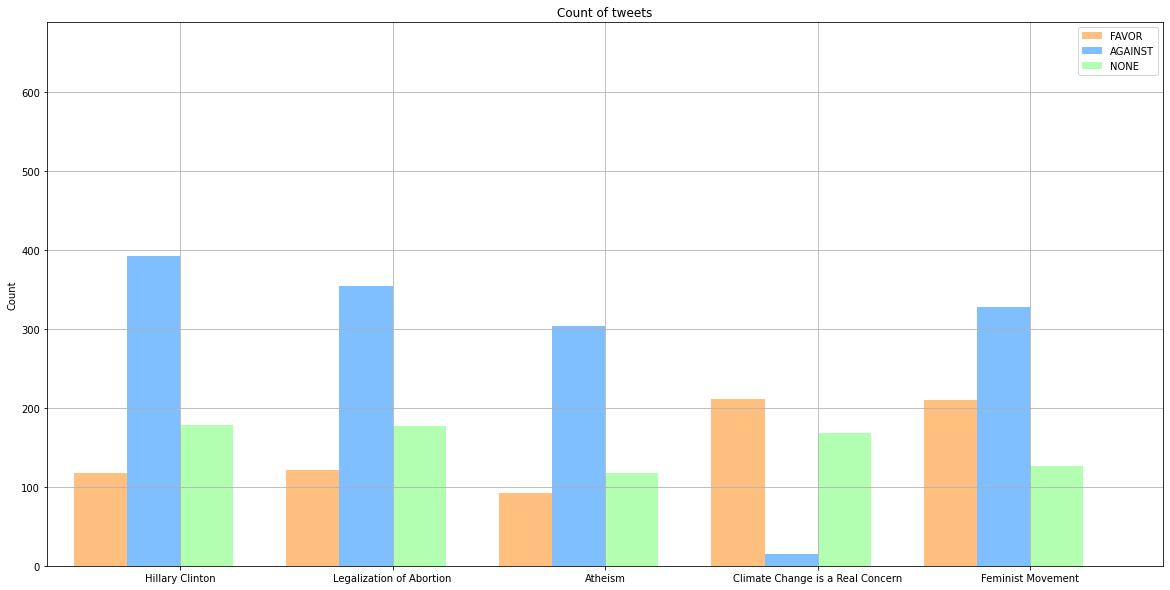

In [88]:
# Grouped bar graph for stance values of each target value.
pos = list(range(len(df['FAVOR']))) 
width = 0.25 
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(pos, df['FAVOR'], width, alpha=0.5, color='#FF8000', label=df['Target'][0]) 
plt.bar([p + width for p in pos], df['AGAINST'], width, alpha=0.5, color='#0080FF', label=df['Target'][1]) 
plt.bar([p + width*2 for p in pos], df['NONE'], width, alpha=0.5, color='#66FF66', label=df['Target'][2]) 
ax.set_ylabel('Count')
ax.set_title('Count of tweets')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df['Target'])
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['FAVOR'] + df['AGAINST'] + df['NONE'])] )
plt.legend(['FAVOR', 'AGAINST', 'NONE'], loc='upper right')
plt.grid()
plt.show()

We can see from the above exploration that there is a large difference between number of tweets of each target value. We can also find out that there is a class imbalance problem present in the data as number of tweets have large difference between each stance for each target. For example, for target value "Climate Change is a Real Concern", there are only 15 tweets with Stance "AGAINST" it.


So below we are using two different appraches to tackle this problem. In the first approach we are considering the whole dataset as an input to a single model and try to build a deep model to train this data. In the second approach we divide the dataset according to the target values and then try to build a model for each target value to predict its stance so there are 5 different models for 5 different target values.


# Approach 1 : Building a model which takes whole data as a input.

The main task is to predict the Stance of a particular tweet based on the tweet content and the target it is mentioned for. 

So for classification purpose we concatenate the tweet statement with its corresponding target value and store it as a complete tweet.


In [213]:
# as we have to use only tweet sentences and Target as an input for detecting the Stance, we concatenate this features into a single feature 
train_data = traindata[['Tweet','Stance','Target']]
train_data["Tweet"] = train_data["Tweet"] + " " + train_data["Target"]
train_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2914, 3)

***Data Exploration***

For futher deep understanding of tweet data we tried some exploration in tweets before preprocessing it. We get a better idea of which kind of preprocessing steps we need to do from it.

---



As a first exploration step, we need to explore the number of words and characters in tweet statements.

In [214]:
# Some more exloration about the tweets which may helps in preprocessing

# Word count in the Tweet column 

train_data['Word_Count'] = train_data['Tweet'].apply(lambda x: len(str(x).split()))


## Character Counts in Tweet column

train_data['Character_Count'] = train_data['Tweet'].apply(lambda x: len(x))


train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Tweet,Stance,Target,Word_Count,Character_Count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68


In the next step of exploration we checked the number of stop words in the sentence as well as the average word length of the tweet.

In [215]:
# Calculating the average word length [calculated using formula =  (Character_Count/Word_Count)]

train_data['Average_Word_length'] = train_data['Character_Count']/train_data['Word_Count']

# Counting the stop words

train_data['Stop_words_count'] = train_data['Tweet'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))

train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5


The next step is to explore the hashtags and mentions in the tweet.  We believe gashtags and mentions play an important role during prediction task. During literature survey we came to know that from hashtags we manually extract some decisions regarding the stance of that tweet.

For example, tag #NoMoreReligions depicts that the tweet should be in FAVOR with target Atheism. while tag #Godswill states probability of the tweet being AGAINST the Atheism. but some tags like #atheism are ambiguous and we cannot predict Stance manually from them.

For this purpose we need to know the number of Hashtags and mentions in the tweet first.

In [216]:
## Count HashTags -> # and mentions -> @

train_data['HashTag_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.startswith("#")])) 

train_data['Mention_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.startswith("@")])) 

train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3,3,1
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7,1,0
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7,0,1
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7,1,0
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5,0,1


In the below step we checked the number of digits and Upper case characters in the tweet. That is because we believe, people mostly write in capital letters when they are either highly in FAVOR or in AGAINST with something.

In [217]:
## Checking the numeric digits present in the tweets

train_data['numeric_digit_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.isdigit()])) 

# Checking the count of Upper Case in the tweet (Because mostly people write in capital when they are Happy or Sad)

train_data['uppercase_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.isupper() and len(x)>3])) 

train_data.head()

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,Hillary Clinton,19,143,7.526316,3,3,1,0,0
1,Hillary is our best choice if we truly want to...,FAVOR,Hillary Clinton,18,105,5.833333,7,1,0,0,0
2,@TheView I think our country is ready for a fe...,AGAINST,Hillary Clinton,18,97,5.388889,7,0,1,0,1
3,I just gave an unhealthy amount of my hard-ear...,AGAINST,Hillary Clinton,21,140,6.666667,7,1,0,0,2
4,@PortiaABoulger Thank you for adding me to you...,NONE,Hillary Clinton,11,68,6.181818,5,0,1,0,0




---

**Preprocessing the tweets**

After some interesting exploration in Tweet column, we started some basic preprocessing. The first and very basic step is to convert the tweet into lowercase.

In [218]:
# Converting to lower case

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: x.lower()) 

train_data['Tweet'].head(2)

0    @tedcruz and, #handovertheserver she wiped cle...
1    hillary is our best choice if we truly want to...
Name: Tweet, dtype: object

the next step is to convert contracted word into their expanded format. This step is needed as we want to seperate the words like 'don't' into 'do not' so that model can understand them clearly.

In [219]:
# Contraction to Expandion [Meaning converting words like "don't" to "do not"]

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i had",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"o'clock": "of the clock",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she had",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they had",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
" n ":"and",
" u ": "you",
}

def con_to_ext(x):
  if type(x) is str:
    for key in contractions:
      value = contractions[key]
      x = x.replace(key, value)
    return x
  else:
    return x

In [220]:
train_data['Tweet'] = train_data['Tweet'].apply(lambda x: con_to_ext(x))
train_data['Tweet'].head(5)

0    @tedcruz and, #handovertheserver she wiped cle...
1    hillary is our best choice if we truly want to...
2    @theview i think our country is ready for a fe...
3    i just gave an unhealthy amount of my hard-ear...
4    @portiaaboulger thank you for adding me to you...
Name: Tweet, dtype: object

The next step of preprocessing we done is to remove the email ids from the tweets as they may contain personal data in alphanumeric format which does not make sense towards Stance detection.

In [221]:
## Count and remove emails from the tweet
import re
train_data['email'] = train_data['Tweet'].apply(lambda x: re.findall(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)',x))

In [222]:
# Counting the number of email present in the dataset 

train_data['email_count'] = train_data['email'].apply(lambda x: len(x))

# Checking if the emails are greater that 1

train_data[train_data['email_count']>0]

,Tweet,Stance,Target,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count,email,email_count
676,(2/2) 300 words and be sent to climateconferen...,FAVOR,Climate Change is a Real Concern,17,142,8.352941,5,3,0,1,0,[climateconference2015@gmail.com],1
2691,worldwide r.e. agents! - support a prolife gro...,AGAINST,Legalization of Abortion,16,129,8.062500,3,1,0,0,2,[proliferealestate@yahoo.com],1


In [223]:
## Removing the emails from the Tweet column.

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: re.sub(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)','',x))

THe next step of preprocessing is to remove special characters and punctuations from the tweets. we removed all the special characters excluding # and @ from the tweets.

After that, we removed extra white spaces from tweets. and removed words which may written in Accented characters.

The last step is to remove stop words from the tweet statements.


In [224]:
## Removing Special characters and punctuations

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9#@]+',' ',x))

## Remove the multiple(extra) spaces

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: " ".join(x.split()))

## Remove the Accented characters (e.g. àÿüûâ)
import unicodedata

def remove_accent(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8','ignore')
  return x

## Applying on tweets
train_data['Tweet'] = train_data['Tweet'].apply(lambda x: remove_accent(x))

### Removing the stop words

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))


train_data['Tweet'].head(5)

0    @tedcruz #handovertheserver wiped clean 30k de...
1    hillary best choice truly want continue progre...
2    @theview think country ready female pres hilla...
3    gave unhealthy hard earned money away big gov ...
4    @portiaaboulger thank adding list hillary clinton
Name: Tweet, dtype: object

The next step is to tokenize (encoding) the preprocessed tweet data and then add padding to the data to make each tweet statement of the same length.

for that we copied the Tweet data into a list named 'text'.

In [225]:
#train_data['Tw'] = train_data['Tweet']
#####
text = train_data['Tweet'].tolist()
text[:3]

['@tedcruz #handovertheserver wiped clean 30k deleted emails explains dereliction duty lies #benghazi etc #tcot hillary clinton',
 'hillary best choice truly want continue progressive nation #ohio hillary clinton',
 '@theview think country ready female pres hillary hillary clinton']

In [226]:
#####
y = train_data['Stance']
y = pd.get_dummies(y).values
y.shape

(2914, 3)

In [227]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(text)

### Calculating the vocabulary size
vocab_size = len(token.word_index)+1
vocab_size

9021

we used 50 as a max length for the padding to make each sentence of max length 50.

In [228]:
## Encoding the text
encoded_text = token.texts_to_sequences(text)
print(encoded_text[:3])

## By default prepadding is done

sentence_max_length = 50
X = pad_sequences(encoded_text, maxlen=sentence_max_length)
print(X.shape)

[[694, 3155, 3156, 1299, 3157, 819, 124, 1859, 3158, 1022, 130, 151, 435, 51, 2, 5], [2, 53, 68, 436, 24, 311, 1023, 173, 1024, 2, 5], [3159, 34, 99, 152, 153, 1860, 2, 2, 5]]
(2914, 50)




---

**Word Embedding and Transfer Learning**

As we can see from the above that we have very small dataset only with 2914 data points of 5 target values. We can see from above exploration that the data also has class imbalance problem so we are using a pretrained vector weights to use better representation of the vocabulary we have in our data set. 

We are using Glove Twitter 100 dimensional pretrained vector present on https://nlp.stanford.edu/projects/glove/

This pretrained vector is present in various dimentions as 50d, 100d and 200d but we are simply using 100d vector for our task.
we make a glove vector dictionary to save all the words from pretrained vector file.

In [229]:
##### Glove Vector
# e.g. hello -0.11 0.23 0.333 0.54 0.65
glove_vectors = dict()
#file = open('/content/drive/My Drive/Colab Notebooks/TweetsDataset/glove.twitter.27B.100d.txt', encoding='utf-8')
file = open('/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/glove.twitter.27B.100d.txt', encoding='utf-8')
glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

We can see from the below code that the Glove vector has almost 1.5 million words present with dimension shape of 100.

In [230]:
### Prints the length of keys in glove vector dictionary
print(len(glove_vectors.keys()))

#### displaying the shape of the glove vector just for testing purpose
print(glove_vectors.get('to').shape)

1193514
(100,)


The next step is to create an Embedded Matrix by mapping each word in our vocabulary with the same word in the Glove Vector.
The words which are not in the Glove vector are added to the list named 'Not_words'.

In [231]:
E_T = np.zeros((vocab_size , 100))
Not_words = list()
for word, i in token.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector
    else:
      #print(word) # Printing the misspelled words
      Not_words.append(word)

print("Embedding Matrix size: ", E_T.size)
print("Words which are not in Embedding Matrix: ", len(Not_words))

Embedding Matrix size:  902100
Words which are not in Embedding Matrix:  2449


The next step is to split the data into Training and Validation datasets. We are using simple train_test_split() function from sklearn to split the data with split size of 0.2 which mean 80% data is used for training the model while remaining 20% data is used for validation purpose to check how well our model is generalizing. 

In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_test.shape)
print("y_val shape: ", y_test.shape)

X_train shape:  (2331, 50)
y_train shape:  (2331, 3)
X_val shape:  (583, 50)
y_val shape:  (583, 3)


We can see from the above code that, 2331 records are used for model training purpose while 583 records are used for validation of the model.

---
 
In the next code cell, we created a baseline model with Transfer Learning layer. 

The model architechture is like encoded input is fed to the Glove pretrained vector to create an Embedding Layer weights. We create an Embedding Layer with the weights generated above and it is our first layer of the model. Output of this layer is given to the LSTM layer with 32 memory units which has dropout rate of 0.5 and recurrent_dropout rate of 0.25. Output of this layer is again passed through the dropout layer of 0.6 value. The output of this dropout layer is fed to the ReLU dense layer of 64 unit for the non-linear activation. This output is again passed though the dropuout layer of 0.6 value and finally fed to the Softmax activation layer with 3 output units which predict the Stance as either 'FAVOR', 'AGAINST' or 'NONE'.

We are using 'categorical_crossentropy' as a error metric and 'Categorical_Accuracy' as a performance metric while compiling the model. We have used basic 'adam' optimizer for the training purpose.




In [233]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
import keras.backend as K
import numpy as np
 
def create_model(embedding_layer):

  model_glove = Sequential()
  model_glove.add(embedding_layer)
  model_glove.add(LSTM(units=32, dropout=0.5, recurrent_dropout= 0.25))
  #model_glove.add(LSTM(units=64, kernel_regularizer=regularizers.l2(0.01)))
  model_glove.add(Dropout(0.6))
  model_glove.add(Dense(64, activation='relu'))
  model_glove.add(Dropout(0.4))
  model_glove.add(Dense(3, activation='softmax'))

  #opt= tf.keras.optimizers.SGD(learning_rate= 0.02, momentum=0.6)
  model_glove.compile(loss='categorical_crossentropy', optimizer='adam')

  return model_glove  

We dont train the embedding layer as we are using pre-trained vector weights in our embedding layer.

In [234]:
vector_size = 100
embedding_layer = Embedding( vocab_size,
                     vector_size,
                     input_length=50,
                     weights=[E_T],
                     trainable=False)
model1 = create_model(embedding_layer)
print(model1.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 100)           902100    
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 195       
Total params: 921,431
Trainable params: 19,331
Non-trainable params: 902,100
__________________________________________

In [235]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

As we have less amount of data available for training, we are using K-fold cross validation technique to train our model for 50 epochs in each of the 3 folds.
The batch size is set to 64 and we trained the data for 50 epochs and 3 folds.
To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.

In [236]:
#from sklearn.model_selection import KFold
#num_folds = 3
#input = np.concatenate((X_train, X_test), axis= 0)
#target = np.concatenate((y_train, y_test), axis= 0)

#kfold = KFold(n_splits=num_folds, shuffle=True)
#K = 1
#for train, test in kfold.split(input, target):
#    print("fold number: ", K)
#    m_histories = {}
#    m_histories['with_TL'] = model.fit(input[train], target[train], batch_size=64, epochs=50, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
#    K = K+1

m_histories = {}
m_histories['with_TL'] = model1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
37/37 [==============================] - 4s 98ms/step - loss: 1.0819 - val_loss: 1.0153
Epoch 2/50
37/37 [==============================] - 3s 71ms/step - loss: 1.0355 - val_loss: 1.0006
Epoch 3/50
37/37 [==============================] - 3s 72ms/step - loss: 1.0236 - val_loss: 0.9887
Epoch 4/50
37/37 [==============================] - 3s 73ms/step - loss: 1.0090 - val_loss: 0.9805
Epoch 5/50
37/37 [==============================] - 3s 72ms/step - loss: 1.0037 - val_loss: 0.9734
Epoch 6/50
37/37 [==============================] - 3s 72ms/step - loss: 0.9810 - val_loss: 0.9658
Epoch 7/50
37/37 [==============================] - 3s 72ms/step - loss: 0.9848 - val_loss: 0.9624
Epoch 8/50
37/37 [==============================] - 3s 72ms/step - loss: 0.9874 - val_loss: 0.9534
Epoch 9/50
37/37 [==============================] - 3s 73ms/step - loss: 0.9697 - val_loss: 0.9469
Epoch 10/50
37/37 [==============================] - 3s 72ms/step - loss: 0.9613 - val_loss: 0.9336
Epoch 11/

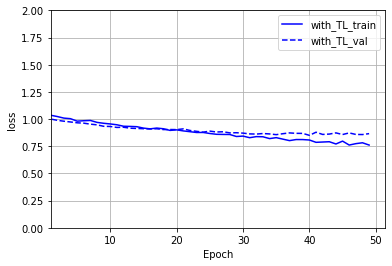

In [237]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

**Evaluating on test data.**

After training the model on training data we are going to predict the data mentioned in the test data set.
But before that, we have preprocess the test data same as the training data.

In [238]:
def preprocessing(data):
   data = data[['Tweet','Stance','Target']]
   data["Tweet"] = data["Tweet"] + " " +data["Target"]
   data['Tweet'] = data['Tweet'].apply(lambda x: x.lower()) 
   data['Tweet'] = data['Tweet'].apply(lambda x: con_to_ext(x))
   data['Tweet'] = data['Tweet'].apply(lambda x: re.sub(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)','',x))
   data['Tweet'] = data['Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9#@]+',' ',x))
   data['Tweet'] = data['Tweet'].apply(lambda x: " ".join(x.split()))
   data['Tweet'] = data['Tweet'].apply(lambda x: remove_accent(x))
   data['Tweet'] = data['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))
   text = data['Tweet'].tolist()
   return text

text = preprocessing(testdata)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [239]:
y = testdata['Stance']
y = pd.get_dummies(y).values
y.shape

(1249, 3)

In [240]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(text)
encoded_text = token.texts_to_sequences(text)
X = pad_sequences(encoded_text, maxlen=sentence_max_length)

In [241]:
y_pred_test = model1.predict_classes(X) 

In [266]:
from sklearn.metrics import f1_score
y_true = np.argmax(y, axis= 1)

f1_score_result = f1_score(y_true, y_pred_test,average='weighted')
result_df.loc[len(result_df)] = ['Approach1_All_data_model', f1_score_result]
f1_score_result

0.4929876235139486



---

# Approach 2 : Building separate model for each target value. i.e. 5 models for 5 different targets in training data



In this approach, we split the whole dataset into 5 subsets each for one Target value and then construct model for each target to predict if the tweet is in FAVOR of that target or AGAINST that target or NONE.

In [243]:
## We are dividing the whole training data into subsets according to the target subject value.

traindata_HC = traindata[traindata['Target'] == "Hillary Clinton"]
testdata_HC = testdata[testdata['Target'] == "Hillary Clinton"]
traindata_AB = traindata[traindata['Target'] == "Legalization of Abortion"]
testdata_AB = testdata[testdata['Target'] == "Legalization of Abortion"]
traindata_AT = traindata[traindata['Target'] == "Atheism"]
testdata_AT = testdata[testdata['Target'] == "Atheism"]
traindata_CC = traindata[traindata['Target'] == "Climate Change is a Real Concern"]
testdata_CC = testdata[testdata['Target'] == "Climate Change is a Real Concern"]
traindata_FM = traindata[traindata['Target'] == "Feminist Movement"]
testdata_FM = testdata[testdata['Target'] == "Feminist Movement"]

From the Approach 1, we now knew the exact preprocessing steps required for the tweets. and hence we used minimum required steps of preprocessing on each subset of training data. 

We have created one method to preprocess the data provided. This preprocessing involves 
1. concatenating Tweet and Targets
2. converting text into Lowercase
3. removing some bad symbols like brackets and other alphanumeric characters except # and @
4. We will apply this method on each dataset created above as a preprocessing data

In [244]:
## We are doing some pre-processing steps prior modelling 
## 1. concatenating Tweet and Targets
## 2. converting text into Lowercase
## 3. removing some bad symbols like brackets and other alphanumeric characters except # and @
## 4. We will apply this method on each dataset created above as a preprocessing data

def TextPreprocessing(traindata):
  traindata = traindata.reset_index(drop= True)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;]')
  BAD_SYMBOLS_RE = re.compile('[^a-z #@]')
  Tweet_Lines = list()
  Tweets = list()
  tknzr = TweetTokenizer()

  def clean_text(text):
      text = text.lower() # lowercase text
      text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
      text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
      text = ''.join(word for word in text.split() if word not in stopwords.words()) # remove stopwords from text
      return text

  traindata['Tweet'] = traindata.Tweet + ' ' + traindata.Target
  lines = traindata['Tweet'].values.tolist()
  for line in lines:
      tokens = tknzr.tokenize(line)
      Tweet_Lines = list()
      for token in tokens:
        token = clean_text(token)
        if token != '' :
          Tweet_Lines.append(token)
      Tweets.append(Tweet_Lines)
          
  return Tweets

In [245]:
Tweets_HC = TextPreprocessing(traindata_HC)
Tweets_AB = TextPreprocessing(traindata_AB)
Tweets_AT = TextPreprocessing(traindata_AT)
Tweets_CC = TextPreprocessing(traindata_CC)
Tweets_FM = TextPreprocessing(traindata_FM)

Test_Tweets_HC = TextPreprocessing(testdata_HC)
Test_Tweets_AB = TextPreprocessing(testdata_AB)
Test_Tweets_AT = TextPreprocessing(testdata_AT)
Test_Tweets_CC = TextPreprocessing(testdata_CC)
Test_Tweets_FM = TextPreprocessing(testdata_FM)

We have to do similar tokenizing and padding task for each of the 5 datasets so we created a generic method which is used to do tokenization and padding.

We have used 40 as a max length while padding. 

In [246]:
## Tokenizing and padding the Tweets data to make it suitable for further modelling.

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = 40
embedding_dim = 100

def Padding(Tweets):  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(Tweets)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X = tokenizer.texts_to_sequences(Tweets)
  X = pad_sequences(X, maxlen=MAX_LENGTH, padding= 'post')
  print('Shape of data tensor:', X.shape)

  return X, word_index

The next step is to split the data for training and validation. We have simply used train_test_split() function from sklearn to split the data with provided split size.

In [247]:
from sklearn.model_selection import train_test_split

def split(X, Y, split_size):
    X_train, X_Val, Y_train, Y_Val = train_test_split(X, Y, test_size= split_size, random_state = 42)
    return X_train, X_Val, Y_train, Y_Val

In [248]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

**Baseline Model**

In the next code cell, we created a baseline model with Transfer Learning layer. 

The model architechture is like encoded input is fed to the Glove pretrained vector to create an Embedding Layer weights. We create an Embedding Layer with the weights generated above and it is our first layer of the model. Output of this layer is given to the LSTM layer with 32 memory units which has dropout rate of 0.5 and recurrent_dropout rate of 0.25. Output of this layer is again passed through the dropout layer of 0.6 value. The output of this dropout layer is fed to the ReLU dense layer of 64 unit for the non-linear activation. This output is again passed though the dropuout layer of 0.6 value and finally fed to the Softmax activation layer with 3 output units which predict the Stance as either 'FAVOR', 'AGAINST' or 'NONE'.

We are using 'categorical_crossentropy' as a error metric and 'Categorical_Accuracy' as a performance metric while compiling the model. We have used basic 'adam' optimizer for the training purpose.

Here we are checking the model with and without transfer learning for each of 5 target related models hence we have created a method which will construct a model as per the provided embedding layer.

In [249]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers

def create_model(embedding_layer):

  model_glove = Sequential()
  model_glove.add(embedding_layer)
  model_glove.add(LSTM(units=32, dropout= 0.5, recurrent_dropout= 0.25, kernel_regularizer=regularizers.l2(0.001)))
  #model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, recurrent_dropout= 0.25)))
  #model_glove.add(LSTM(units=64, kernel_regularizer=regularizers.l2(0.01)))
  model_glove.add(Dropout(0.4))
  model_glove.add(Dense(64, activation='relu'))
  model_glove.add(Dropout(0.3))
  model_glove.add(Dense(3, activation='softmax'))

  #opt= tf.keras.optimizers.SGD(learning_rate= 0.015, momentum= 0.9)
  model_glove.compile(loss='categorical_crossentropy', optimizer='adam')

  return model_glove  

**Word Embedding and Transfer Learning**

As we can see from the above that we have very small dataset only with 2914 data points of 5 target values. We can see from above exploration that the data also has class imbalance problem so we are using a pretrained vector weights to use better representation of the vocabulary we have in our data set. 

We are using Glove Twitter 100 dimensional pretrained vector present on https://nlp.stanford.edu/projects/glove/

This pretrained vector is present in various dimentions as 50d, 100d and 200d but we are simply using 100d vector for our task.
we make a glove vector dictionary to save all the words from pretrained vector file.

In [250]:
#file = open('/content/drive/My Drive/Colab Notebooks/TweetsDataset/glove.twitter.27B.100d.txt', encoding='utf-8')
file = open('/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/glove.twitter.27B.100d.txt', encoding='utf-8')
glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

# **1. modelling for tweets related to Target : Hillary Clinton**

First we check the preprocessed tweet data for target Hillary Clinton

In [268]:
Tweets_HC[:1]

[['@tedcruz',
  '#handovertheserver',
  'wiped',
  'clean',
  'deleted',
  'emails',
  'explains',
  'dereliction',
  'duty',
  'lies',
  '#benghazi',
  'etc',
  '#tcot',
  'hillary',
  'clinton']]

The next step is to call method padding which will tokenize the tweets and pad them with max length of 40.

In [269]:
X, word_index = Padding(Tweets_HC)
Y = pd.get_dummies(traindata_HC['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2966 unique tokens.
Shape of data tensor: (689, 40)
Shape of label tensor: (689, 3)


The next step is to split the above data into training and validation. We are using above mentioned split() method by passing 0.2 as a split size which means 20% of the data is reserved for validation and remaining 80% data is used for training the model.

In [270]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (551, 40)
Y train shape:  (551, 3)
X Val shape:  (138, 40)
Y Val shape:  (138, 3)


**Model without Transfer Learning**

First we try to model without transfer learning.


In [271]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model2 = create_model(embedding_layer)
print(model2.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 40, 100)           296700    
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 195       
Total params: 316,031
Trainable params: 316,031
Non-trainable params: 0
_______________________________________________

As we have less amount of data available for training, we are using K-fold cross validation technique to train our model for 20 epochs in each of the 3 folds.
The batch size is set to 32 and we trained the data for 20 epochs and 3 folds.

To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.

In [272]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model2.fit(input[train], target[train], batch_size=32, epochs=20, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/20
15/15 [==============================] - 2s 120ms/step - loss: 1.1546 - val_loss: 1.0937
Epoch 2/20
15/15 [==============================] - 1s 59ms/step - loss: 1.0801 - val_loss: 1.0722
Epoch 3/20
15/15 [==============================] - 1s 58ms/step - loss: 1.0341 - val_loss: 1.0538
Epoch 4/20
15/15 [==============================] - 1s 58ms/step - loss: 1.0301 - val_loss: 1.0454
Epoch 5/20
15/15 [==============================] - 1s 61ms/step - loss: 1.0086 - val_loss: 1.0350
Epoch 6/20
15/15 [==============================] - 1s 65ms/step - loss: 1.0246 - val_loss: 1.0291
Epoch 7/20
15/15 [==============================] - 1s 85ms/step - loss: 1.0015 - val_loss: 1.0266
Epoch 8/20
15/15 [==============================] - 1s 90ms/step - loss: 1.0243 - val_loss: 1.0191
Epoch 9/20
15/15 [==============================] - 1s 94ms/step - loss: 0.9920 - val_loss: 1.0161
Epoch 10/20
15/15 [==============================] - 1s 85ms/step - loss: 0.9995 - val_loss:

We tried to plot learning curves for both validation and training data on Catergorical Crossentropy.


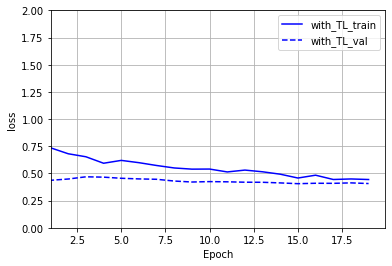

In [273]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [274]:
X_test, test_word_index = Padding(Test_Tweets_HC)
Y_true = pd.get_dummies(testdata_HC['Stance']).values
print('Shape of label tensor:', Y_true.shape)

Found 1600 unique tokens.
Shape of data tensor: (295, 40)
Shape of label tensor: (295, 3)


In [275]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

Y_true = np.argmax(Y_true, axis= 1)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_HC_WTF', f1_score_result]
f1_score_result

0.5317073170731706

**Model with Transfer Learning**

we try to model with transfer learning.

In [276]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

296700

In [277]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model2 = create_model(embedding_layer_TL)
print(model2.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 40, 100)           296700    
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 195       
Total params: 316,031
Trainable params: 19,331
Non-trainable params: 296,700
__________________________________________

In [278]:
m_histories['with_TL'] = model2.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
18/18 [==============================] - 2s 94ms/step - loss: 1.1714 - val_loss: 1.1139
Epoch 2/50
18/18 [==============================] - 1s 48ms/step - loss: 1.0719 - val_loss: 1.0478
Epoch 3/50
18/18 [==============================] - 1s 47ms/step - loss: 1.0306 - val_loss: 1.0259
Epoch 4/50
18/18 [==============================] - 1s 48ms/step - loss: 1.0141 - val_loss: 1.0154
Epoch 5/50
18/18 [==============================] - 1s 47ms/step - loss: 0.9993 - val_loss: 1.0021
Epoch 6/50
18/18 [==============================] - 1s 47ms/step - loss: 0.9998 - val_loss: 0.9981
Epoch 7/50
18/18 [==============================] - 1s 47ms/step - loss: 0.9832 - val_loss: 0.9900
Epoch 8/50
18/18 [==============================] - 1s 48ms/step - loss: 0.9700 - val_loss: 0.9819
Epoch 9/50
18/18 [==============================] - 1s 47ms/step - loss: 0.9557 - val_loss: 0.9542
Epoch 10/50
18/18 [==============================] - 1s 48ms/step - loss: 0.9449 - val_loss: 0.9419
Epoch 11/

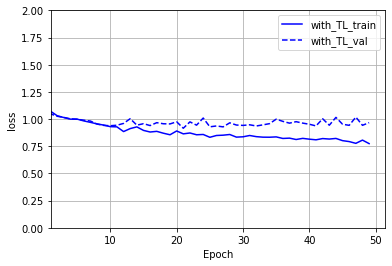

In [279]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [280]:
Y_pred = model2.predict_classes(X_test)

In [281]:
from sklearn.metrics import f1_score
f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_HC_TF', f1_score_result]
f1_score_result

0.6245059288537549

# **2. modelling for tweets related to Target : Legalization of Abortion**

First we check the preprocessed tweet data for target Legalization of Abortion

In [282]:
Tweets_AB[:1]

[['laid',
  'law',
  'abortion',
  'bioethics',
  'class',
  '#catholic',
  'legalization',
  'abortion']]

The next step is to call method padding which will tokenize the tweets and pad them with max length of 40.

In [283]:
X, word_index = Padding(Tweets_AB)
Y = pd.get_dummies(traindata_AB['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2771 unique tokens.
Shape of data tensor: (653, 40)
Shape of label tensor: (653, 3)


The next step is to split the above data into training and validation. We are using above mentioned split() method by passing 0.2 as a split size which means 20% of the data is reserved for validation and remaining 80% data is used for training the model.

In [284]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (522, 40)
Y train shape:  (522, 3)
X Val shape:  (131, 40)
Y Val shape:  (131, 3)


**Without Transfer Learning**

In [285]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model2 = create_model(embedding_layer)
print(model2.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 40, 100)           277200    
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 195       
Total params: 296,531
Trainable params: 296,531
Non-trainable params: 0
_______________________________________________

As we have less amount of data available for training, we are using K-fold cross validation technique to train our model for 20 epochs in each of the 3 folds.
The batch size is set to 32 and we trained the data for 20 epochs and 3 folds.

To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.

In [286]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model2.fit(input[train], target[train], batch_size=32, epochs=20, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/20
14/14 [==============================] - 2s 129ms/step - loss: 1.1508 - val_loss: 1.1187
Epoch 2/20
14/14 [==============================] - 1s 59ms/step - loss: 1.0825 - val_loss: 1.1028
Epoch 3/20
14/14 [==============================] - 1s 58ms/step - loss: 1.0655 - val_loss: 1.0901
Epoch 4/20
14/14 [==============================] - 1s 59ms/step - loss: 1.0372 - val_loss: 1.0880
Epoch 5/20
14/14 [==============================] - 1s 59ms/step - loss: 1.0514 - val_loss: 1.0705
Epoch 6/20
14/14 [==============================] - 1s 61ms/step - loss: 1.0360 - val_loss: 1.0636
Epoch 7/20
14/14 [==============================] - 1s 59ms/step - loss: 1.0254 - val_loss: 1.0664
Epoch 8/20
14/14 [==============================] - 1s 57ms/step - loss: 1.0269 - val_loss: 1.0534
Epoch 9/20
14/14 [==============================] - 1s 58ms/step - loss: 1.0078 - val_loss: 1.0530
Epoch 10/20
14/14 [==============================] - 1s 60ms/step - loss: 1.0079 - val_loss:

We tried to plot learning curves for both validation and training data on Catergorical Crossentropy as well as for Catergorical Accuracy.

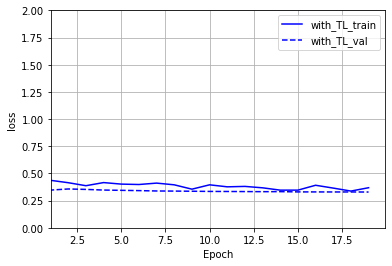

In [287]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [288]:
X_test, test_word_index = Padding(Test_Tweets_AB)
Y_true = pd.get_dummies(testdata_AB['Stance']).values
print('Shape of label tensor:', Y_true.shape)

Found 1526 unique tokens.
Shape of data tensor: (280, 40)
Shape of label tensor: (280, 3)


In [289]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

Y_true = np.argmax(Y_true, axis= 1)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_AB_WTF', f1_score_result]
f1_score_result

0.544041450777202

**With Transfer Learning**

In [290]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

277200

In [291]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model2 = create_model(embedding_layer_TL)
print(model2.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 40, 100)           277200    
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_38 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 195       
Total params: 296,531
Trainable params: 19,331
Non-trainable params: 277,200
__________________________________________

In [292]:
m_histories['with_TL'] = model2.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
17/17 [==============================] - 2s 98ms/step - loss: 1.1817 - val_loss: 1.1335
Epoch 2/50
17/17 [==============================] - 1s 46ms/step - loss: 1.1147 - val_loss: 1.0243
Epoch 3/50
17/17 [==============================] - 1s 46ms/step - loss: 1.0634 - val_loss: 1.0015
Epoch 4/50
17/17 [==============================] - 1s 49ms/step - loss: 1.0563 - val_loss: 1.0061
Epoch 5/50
17/17 [==============================] - 1s 49ms/step - loss: 1.0389 - val_loss: 0.9713
Epoch 6/50
17/17 [==============================] - 1s 50ms/step - loss: 1.0082 - val_loss: 0.9358
Epoch 7/50
17/17 [==============================] - 1s 48ms/step - loss: 0.9708 - val_loss: 0.8833
Epoch 8/50
17/17 [==============================] - 1s 49ms/step - loss: 0.9507 - val_loss: 0.9068
Epoch 9/50
17/17 [==============================] - 1s 46ms/step - loss: 0.9319 - val_loss: 0.9146
Epoch 10/50
17/17 [==============================] - 1s 47ms/step - loss: 0.9365 - val_loss: 0.8806
Epoch 11/

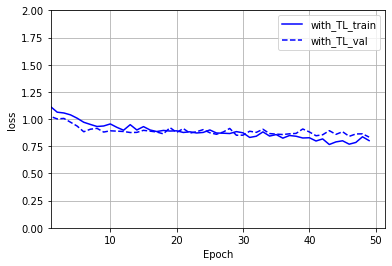

In [293]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [294]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_AB_TF', f1_score_result]
f1_score_result

0.5545454545454545

# **3. modelling for tweets related to Target : Atheism**

First we check the preprocessed tweet data for target Atheism

In [295]:
Tweets_AT[:1]

[['dear',
  'lord',
  'thank',
  'ur',
  'blessings',
  'forgive',
  'sins',
  'lord',
  'give',
  'strength',
  'energy',
  'busy',
  'day',
  'ahead',
  '#blessed',
  '#hope',
  '#semst',
  'atheism']]

The next step is to call method padding which will tokenize the tweets and pad them with max length of 40.

In [296]:
X, word_index = Padding(Tweets_AT)
Y = pd.get_dummies(traindata_AT['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2462 unique tokens.
Shape of data tensor: (513, 40)
Shape of label tensor: (513, 3)


The next step is to split the above data into training and validation. We are using above mentioned split() method by passing 0.2 as a split size which means 20% of the data is reserved for validation and remaining 80% data is used for training the model.

In [297]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (410, 40)
Y train shape:  (410, 3)
X Val shape:  (103, 40)
Y Val shape:  (103, 3)


**Without Transfer Learning**

In [298]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model2 = create_model(embedding_layer)
print(model2.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 40, 100)           246300    
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 195       
Total params: 265,631
Trainable params: 265,631
Non-trainable params: 0
_______________________________________________

As we have less amount of data available for training, we are using K-fold cross validation technique to train our model for 20 epochs in each of the 3 folds.
The batch size is set to 32 and we trained the data for 20 epochs and 3 folds.

To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.


In [299]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model2.fit(input[train], target[train], batch_size=32, epochs=20, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/20
11/11 [==============================] - 2s 160ms/step - loss: 1.1561 - val_loss: 1.0966
Epoch 2/20
11/11 [==============================] - 1s 80ms/step - loss: 1.0624 - val_loss: 1.0491
Epoch 3/20
11/11 [==============================] - 1s 70ms/step - loss: 1.0400 - val_loss: 1.0320
Epoch 4/20
11/11 [==============================] - 1s 66ms/step - loss: 1.0349 - val_loss: 1.0232
Epoch 5/20
11/11 [==============================] - 1s 74ms/step - loss: 1.0261 - val_loss: 1.0145
Epoch 6/20
11/11 [==============================] - 1s 64ms/step - loss: 1.0120 - val_loss: 1.0073
Epoch 7/20
11/11 [==============================] - 1s 66ms/step - loss: 1.0175 - val_loss: 1.0032
Epoch 8/20
11/11 [==============================] - 1s 72ms/step - loss: 0.9983 - val_loss: 0.9983
Epoch 9/20
11/11 [==============================] - 1s 66ms/step - loss: 0.9949 - val_loss: 0.9944
Epoch 10/20
11/11 [==============================] - 1s 78ms/step - loss: 0.9911 - val_loss:

We tried to plot learning curves for both validation and training data on Catergorical Crossentropy .

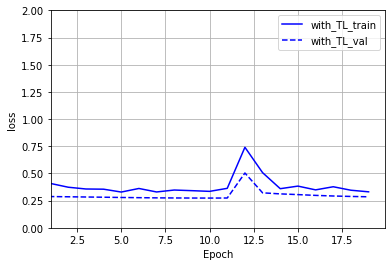

In [300]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [301]:
X_test, test_word_index = Padding(Test_Tweets_AT)
Y_true = pd.get_dummies(testdata_AT['Stance']).values
print('Shape of label tensor:', Y_true.shape)

Found 1339 unique tokens.
Shape of data tensor: (220, 40)
Shape of label tensor: (220, 3)


In [302]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

Y_true = np.argmax(Y_true, axis= 1)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_AT_WTF', f1_score_result]
f1_score_result

0.6006389776357827

**With Transfer Learning**

In [303]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

246300

In [304]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model2 = create_model(embedding_layer_TL)
print(model2.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 40, 100)           246300    
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_42 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 195       
Total params: 265,631
Trainable params: 19,331
Non-trainable params: 246,300
__________________________________________

In [305]:
m_histories['with_TL'] = model2.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
13/13 [==============================] - 1s 114ms/step - loss: 1.1826 - val_loss: 1.1559
Epoch 2/50
13/13 [==============================] - 1s 49ms/step - loss: 1.0992 - val_loss: 1.0884
Epoch 3/50
13/13 [==============================] - 1s 48ms/step - loss: 1.0316 - val_loss: 1.0746
Epoch 4/50
13/13 [==============================] - 1s 48ms/step - loss: 0.9901 - val_loss: 1.0578
Epoch 5/50
13/13 [==============================] - 1s 45ms/step - loss: 0.9697 - val_loss: 1.0335
Epoch 6/50
13/13 [==============================] - 1s 45ms/step - loss: 0.9065 - val_loss: 0.8976
Epoch 7/50
13/13 [==============================] - 1s 46ms/step - loss: 0.8393 - val_loss: 0.8640
Epoch 8/50
13/13 [==============================] - 1s 46ms/step - loss: 0.8224 - val_loss: 0.8611
Epoch 9/50
13/13 [==============================] - 1s 47ms/step - loss: 0.8010 - val_loss: 0.8655
Epoch 10/50
13/13 [==============================] - 1s 45ms/step - loss: 0.7954 - val_loss: 0.8758
Epoch 11

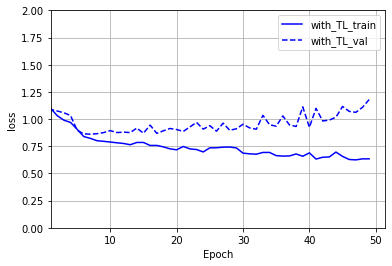

In [306]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [307]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_AT_TF', f1_score_result]
f1_score_result

0.7157894736842105

# **4. Modelling for tweets related to target: Climate Change is a Real Concern**

First we check the preprocessed tweet data for target Climate Change is a Real Concern

In [308]:
Tweets_CC[:1]

[['cant',
  'deny',
  'really',
  'happening',
  '#semst',
  'climate',
  'change',
  'real',
  'concern']]

The next step is to call method padding which will tokenize the tweets and pad them with max length of 40.

In [309]:
X, word_index = Padding(Tweets_CC)
Y = pd.get_dummies(traindata_CC['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 2281 unique tokens.
Shape of data tensor: (395, 40)
Shape of label tensor: (395, 3)


The next step is to split the above data into training and validation. We are using above mentioned split() method by passing 0.2 as a split size which means 20% of the data is reserved for validation and remaining 80% data is used for training the model.

In [310]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (316, 40)
Y train shape:  (316, 3)
X Val shape:  (79, 40)
Y Val shape:  (79, 3)


**Without Transfer Learning**

In [311]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model2 = create_model(embedding_layer)
print(model2.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 100)           228200    
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 195       
Total params: 247,531
Trainable params: 247,531
Non-trainable params: 0
_______________________________________________

As we have less amount of data available for training, we are using K-fold cross validation technique to train our model for 20 epochs in each of the 3 folds.
The batch size is set to 32 and we trained the data for 20 epochs and 3 folds.

To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.

In [312]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model2.fit(input[train], target[train], batch_size=32, epochs=20, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/20
9/9 [==============================] - 1s 158ms/step - loss: 1.1797 - val_loss: 1.1293
Epoch 2/20
9/9 [==============================] - 0s 55ms/step - loss: 1.0849 - val_loss: 1.0119
Epoch 3/20
9/9 [==============================] - 0s 54ms/step - loss: 0.9462 - val_loss: 0.9153
Epoch 4/20
9/9 [==============================] - 1s 58ms/step - loss: 0.9381 - val_loss: 0.9172
Epoch 5/20
9/9 [==============================] - 0s 54ms/step - loss: 0.9155 - val_loss: 0.9054
Epoch 6/20
9/9 [==============================] - 0s 55ms/step - loss: 0.8763 - val_loss: 0.8990
Epoch 7/20
9/9 [==============================] - 1s 57ms/step - loss: 0.8787 - val_loss: 0.8896
Epoch 8/20
9/9 [==============================] - 0s 55ms/step - loss: 0.8792 - val_loss: 0.8843
Epoch 9/20
9/9 [==============================] - 0s 54ms/step - loss: 0.8709 - val_loss: 0.8785
Epoch 10/20
9/9 [==============================] - 1s 61ms/step - loss: 0.8688 - val_loss: 0.8757
Epoch 11/20


We tried to plot learning curves for both validation and training data on Catergorical Crossentropy.

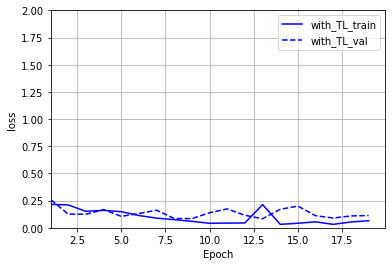

In [313]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [314]:
X_test, test_word_index = Padding(Test_Tweets_CC)
Y_true = pd.get_dummies(testdata_CC['Stance']).values
print('Shape of label tensor:', Y_true.shape)

Found 1167 unique tokens.
Shape of data tensor: (169, 40)
Shape of label tensor: (169, 3)


In [315]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

Y_true = np.argmax(Y_true, axis= 1)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_CC_WTF', f1_score_result]
f1_score_result

0.6167400881057269

**With Transfer Learning**

In [316]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

228200

In [317]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model2 = create_model(embedding_layer_TL)
print(model2.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 40, 100)           228200    
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_46 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 195       
Total params: 247,531
Trainable params: 19,331
Non-trainable params: 228,200
__________________________________________

In [318]:
m_histories['with_TL'] = model2.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
10/10 [==============================] - 1s 129ms/step - loss: 1.1816 - val_loss: 1.1478
Epoch 2/50
10/10 [==============================] - 0s 45ms/step - loss: 1.0765 - val_loss: 1.0296
Epoch 3/50
10/10 [==============================] - 0s 50ms/step - loss: 0.9418 - val_loss: 1.0231
Epoch 4/50
10/10 [==============================] - 0s 45ms/step - loss: 0.9003 - val_loss: 0.9596
Epoch 5/50
10/10 [==============================] - 0s 46ms/step - loss: 0.8780 - val_loss: 0.9607
Epoch 6/50
10/10 [==============================] - 0s 44ms/step - loss: 0.8713 - val_loss: 0.9520
Epoch 7/50
10/10 [==============================] - 0s 47ms/step - loss: 0.8541 - val_loss: 0.9504
Epoch 8/50
10/10 [==============================] - 0s 45ms/step - loss: 0.8578 - val_loss: 0.9490
Epoch 9/50
10/10 [==============================] - 0s 47ms/step - loss: 0.8399 - val_loss: 0.9319
Epoch 10/50
10/10 [==============================] - 0s 50ms/step - loss: 0.8320 - val_loss: 0.9523
Epoch 11

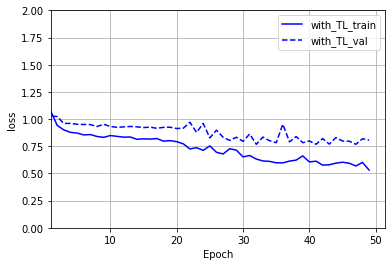

In [319]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [320]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_CC_TF', f1_score_result]
f1_score_result

0.6375545851528384

# **5. Modelling for tweets related to target: Feminist Movement**

First we check the preprocessed tweet data for target Feminist Movement

In [321]:
Tweets_FM[:1]

[['always',
  'delight',
  'see',
  'chestdrumming',
  'alpha',
  'males',
  'hiss',
  'scuttle',
  'backwards',
  'wall',
  'feminist',
  'enters',
  'room',
  '#manly',
  '#semst',
  'feminist',
  'movement']]

The next step is to call method padding which will tokenize the tweets and pad them with max length of 40.

In [322]:
X, word_index = Padding(Tweets_FM)
Y = pd.get_dummies(traindata_FM['Stance']).values
print('Shape of label tensor:', Y.shape)

Found 3031 unique tokens.
Shape of data tensor: (664, 40)
Shape of label tensor: (664, 3)


The next step is to split the above data into training and validation. We are using above mentioned split() method by passing 0.2 as a split size which means 20% of the data is reserved for validation and remaining 80% data is used for training the model.

In [323]:
X_train, X_Val, Y_train, Y_Val = split(X, Y, 0.2)
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("X Val shape: ", X_Val.shape)
print("Y Val shape: ", Y_Val.shape)

X train shape:  (531, 40)
Y train shape:  (531, 3)
X Val shape:  (133, 40)
Y Val shape:  (133, 3)


**Without Transfer Learning**

In [324]:
embedding_layer = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model2 = create_model(embedding_layer)
print(model2.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 40, 100)           303200    
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 195       
Total params: 322,531
Trainable params: 322,531
Non-trainable params: 0
_______________________________________________

As we have less amount of data available for training, we are using K-fold cross validation technique to train our model for 50 epochs in each of the 3 folds.
The batch size is set to 64 and we trained the data for 50 epochs and 3 folds.

From the below output we can see that the model achieved categorical accuracy of about 74% on the validation data set.

To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.

In [325]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_Val), axis= 0)
target = np.concatenate((Y_train, Y_Val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)
    m_histories = {}
    m_histories['with_TL'] = model2.fit(input[train], target[train], batch_size=32, epochs=20, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/with_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/20
14/14 [==============================] - 2s 129ms/step - loss: 1.1897 - val_loss: 1.1553
Epoch 2/20
14/14 [==============================] - 1s 60ms/step - loss: 1.1229 - val_loss: 1.1182
Epoch 3/20
14/14 [==============================] - 1s 63ms/step - loss: 1.1138 - val_loss: 1.1054
Epoch 4/20
14/14 [==============================] - 1s 61ms/step - loss: 1.0808 - val_loss: 1.0955
Epoch 5/20
14/14 [==============================] - 1s 62ms/step - loss: 1.0773 - val_loss: 1.0858
Epoch 6/20
14/14 [==============================] - 1s 60ms/step - loss: 1.0692 - val_loss: 1.0798
Epoch 7/20
14/14 [==============================] - 1s 60ms/step - loss: 1.0572 - val_loss: 1.0751
Epoch 8/20
14/14 [==============================] - 1s 65ms/step - loss: 1.0497 - val_loss: 1.0740
Epoch 9/20
14/14 [==============================] - 1s 62ms/step - loss: 1.0502 - val_loss: 1.0683
Epoch 10/20
14/14 [==============================] - 1s 61ms/step - loss: 1.0424 - val_loss:

We tried to plot learning curves for both validation and training data on Catergorical Crossentropy as well as for Catergorical Accuracy.

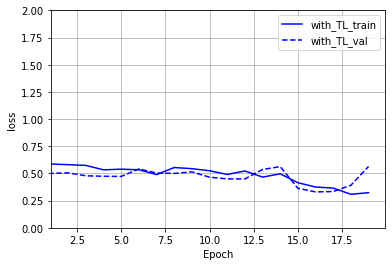

In [326]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [327]:
X_test, test_word_index = Padding(Test_Tweets_FM)
Y_true = pd.get_dummies(testdata_FM['Stance']).values
print('Shape of label tensor:', Y_true.shape)

Found 1609 unique tokens.
Shape of data tensor: (285, 40)
Shape of label tensor: (285, 3)


In [328]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

Y_true = np.argmax(Y_true, axis= 1)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_FM_WTF', f1_score_result]
f1_score_result

0.43737574552683894

**With Transfer Learning**

In [329]:
E_T = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector

E_T.size

303200

In [330]:
embedding_layer_TL = Embedding(len(word_index)+1,
                                embedding_dim,
                                weights=[E_T],
                                input_length=MAX_LENGTH,
                                trainable=False)
model2 = create_model(embedding_layer_TL)
print(model2.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 40, 100)           303200    
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_50 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 195       
Total params: 322,531
Trainable params: 19,331
Non-trainable params: 303,200
__________________________________________

In [331]:
m_histories['with_TL'] = model2.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_Val, Y_Val), callbacks=get_callbacks('models/with_TL'), verbose=1)   

Epoch 1/50
17/17 [==============================] - 2s 99ms/step - loss: 1.1853 - val_loss: 1.1562
Epoch 2/50
17/17 [==============================] - 1s 50ms/step - loss: 1.1166 - val_loss: 1.1023
Epoch 3/50
17/17 [==============================] - 1s 48ms/step - loss: 1.0762 - val_loss: 1.0850
Epoch 4/50
17/17 [==============================] - 1s 48ms/step - loss: 1.0627 - val_loss: 1.0732
Epoch 5/50
17/17 [==============================] - 1s 52ms/step - loss: 1.0539 - val_loss: 1.0639
Epoch 6/50
17/17 [==============================] - 1s 49ms/step - loss: 1.0292 - val_loss: 1.0295
Epoch 7/50
17/17 [==============================] - 1s 50ms/step - loss: 1.0208 - val_loss: 1.0494
Epoch 8/50
17/17 [==============================] - 1s 51ms/step - loss: 1.0297 - val_loss: 1.0585
Epoch 9/50
17/17 [==============================] - 1s 46ms/step - loss: 0.9866 - val_loss: 1.0284
Epoch 10/50
17/17 [==============================] - 1s 46ms/step - loss: 0.9909 - val_loss: 1.0142
Epoch 11/

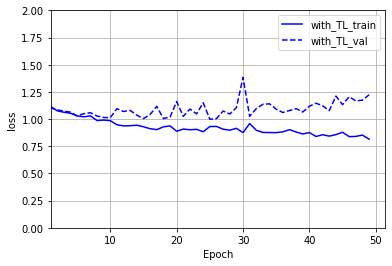

In [332]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [333]:
from sklearn.metrics import f1_score

Y_pred = model2.predict_classes(X_test)

f1_score_result = f1_score(Y_true, Y_pred,labels = [0,1], average='micro')
result_df.loc[len(result_df)] = ['Approach2_FM_TF', f1_score_result]
f1_score_result

0.6611226611226612

In [334]:
result_df

,model,F1_score
0,Approach1_All_data_model,0.492988
1,Approach2_HC_WTF,0.531707
2,Approach2_HC_TF,0.624506
3,Approach2_AB_WTF,0.544041
4,Approach2_AB_TF,0.554545
5,Approach2_AT_WTF,0.600639
6,Approach2_AT_TF,0.715789
7,Approach2_CC_WTF,0.616740
8,Approach2_CC_TF,0.637555
9,Approach2_FM_WTF,0.437376


#Independent Evaluation on sample sunseen data

**Reading the dataset for independent evaluation**

We have sampled a small dataset consisting of 11 tweets along with their Topic and Stance values. Our aim to check if our model is performing as expected on this data.
But for that, we have to preprocess and tokenize the data same as that for training process.

In [335]:
ide = pd.read_csv("/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment2/IndependentEvaluation .csv")

In [336]:
ide.head()

,Tweet,Target,Stance
0,"Crooked Hillary clinton deleted 33,000 emails ...",Hillary Clinton,Against
1,HillaryClinton when you go to prison for defra...,Hillary Clinton,Favor
2,HillaryClinton is Calling for love and Kindness,Hillary Clinton,Favor
3,There is no such thing as #Abortion upto the p...,Legalization of Abortion,Against
4,The Left really needs to reclaim atheism,Atheism,Favor


In [337]:
# as we have to use only tweet sentences and Target as an input for detecting the Stance, we concatenate this features into a single feature 
ide["Tweet"] = ide["Tweet"] + " " + ide["Target"]
ide.shape

(11, 3)

**Preprocessing the independent evaluation dataset**

In [338]:
# Converting to lower case

ide['Tweet'] = ide['Tweet'].apply(lambda x: x.lower()) 

ide['Tweet'].head(2)

0    crooked hillary clinton deleted 33,000 emails ...
1    hillaryclinton when you go to prison for defra...
Name: Tweet, dtype: object

In [339]:
# Contraction to Expandion [Meaning converting words like "don't" to "do not"]

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i had",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"o'clock": "of the clock",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she had",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they had",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
" n ":"and",
" u ": "you",
}

def con_to_ext(x):
  if type(x) is str:
    for key in contractions:
      value = contractions[key]
      x = x.replace(key, value)
    return x
  else:
    return x

In [340]:
ide['Tweet'] = ide['Tweet'].apply(lambda x: con_to_ext(x))
ide['Tweet'].head(5)

0    crooked hillary clinton deleted 33,000 emails ...
1    hillaryclinton when you go to prison for defra...
2    hillaryclinton is calling for love and kindnes...
3    there is no such thing as #abortion upto the p...
4     the left really needs to reclaim atheism atheism
Name: Tweet, dtype: object

In [341]:
## Removing the emails from the Tweet column.

ide['Tweet'] = ide['Tweet'].apply(lambda x: re.sub(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)','',x))

In [342]:
## Removing Special characters and punctuations

ide['Tweet'] = ide['Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9#@]+',' ',x))

## Remove the multiple(extra) spaces

ide['Tweet'] = ide['Tweet'].apply(lambda x: " ".join(x.split()))

## Remove the Accented characters (e.g. àÿüûâ)
import unicodedata

def remove_accent(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8','ignore')
  return x

## Applying on tweets
ide['Tweet'] = ide['Tweet'].apply(lambda x: remove_accent(x))

### Removing the stop words

ide['Tweet'] = ide['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))


ide['Tweet'].head(5)

0    crooked hillary clinton deleted 33 000 emails ...
1    hillaryclinton prison defrauding america perju...
2    hillaryclinton calling love kindness hillary c...
3    thing #abortion upto point birth legalization ...
4                   left needs reclaim atheism atheism
Name: Tweet, dtype: object

In [343]:
# Converting the Tweet text to list
text = ide['Tweet'].tolist()
text[:3]

['crooked hillary clinton deleted 33 000 emails subpoenaed united states congress guilty run rigged system hillary clinton',
 'hillaryclinton prison defrauding america perjury room board free hillary clinton',
 'hillaryclinton calling love kindness hillary clinton']

In [344]:
##### Converting categorical variable into dummy/indicator variables.
y = ide['Stance']
y = pd.get_dummies(y).values
y.shape

(11, 3)

In [345]:
# Tokenizing the text

from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(text)

### Calculating the vocabulary size
vocab_size = len(token.word_index)+1
vocab_size

92

In [346]:
## Encoding the text
encoded_text = token.texts_to_sequences(text)
print(encoded_text[:3])

## prepadding is done with the maxlength 50

sentence_max_length = 50
X = pad_sequences(encoded_text, maxlen=sentence_max_length)
print(X.shape)

[[10, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 4], [7, 23, 24, 25, 26, 27, 28, 29, 3, 4], [7, 30, 31, 32, 3, 4]]
(11, 50)


In [347]:
# Checking the shape of X features variable
X.shape

(11, 50)

In [348]:
# Checking the shape of y variable
y.shape

(11, 3)

In [349]:
y_train = X
y_val = y

In [350]:
# Predicting the features given in the independent evaluation metric 
y_pred_test = model1.predict_classes(y_train)

In [351]:
# Converting the np array to original form

from sklearn.metrics import f1_score
y_val = np.argmax(y, axis= 1)

# Calculating the f1-score of the predicted output and actual output.

f1_score_result = f1_score(y_val, y_pred_test,average='weighted')
#result_df.loc[len(result_df)] = ['Approach1_All_data_model', f1_score_result]
f1_score_result

0.5714285714285715